# Tensorflow Image Classification 
Author: Dennis Trollsfjord

Followed tutorial by tensorflow found [here](https://www.tensorflow.org/tutorials/images/classification), with modifications adapted for our implementation. 

## Setup
Installing required python packages. Then importing the packages needed. 

In [1]:
%%capture
%pip install matplotlib numpy tensorflow tensorflow_datasets

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds  
from datetime import datetime


## Dataset 

### Description
The [rock paper scissor dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) is a dataset provided by [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) (TFDS). The dataset consist of 2520 images for training and 372 for testing. The images has the tensorflow shape of (300, 300, 3).

### License 
"_The dataset is licensed as a CC By 2.0, free for you to share and adapt for all uses, commercial or non-commercial. Please attribute and give appropriate credit to Laurence Moroney (lmoroney@gmail.com / laurencemoroney.com), and place no additional restrictions on your users as outlined here._" which can be found [here](https://laurencemoroney.com/datasets.html).

### Usage
In the following code section we load the dataset, including information about the dataset. After the dataset is loaded with the information both are asserted to verify that the type of the given objects is correct. 

Then the whole dataset is split into 3 parts, test, validate and train, where validate is 20% of the 'train' dataset. We take out the size of each dataset as well as the number of labels and print the result so that we know the dataset has been loaded correctly. The tensorflow dataset should result in the sizes (dataset_train : 2016), (dataset_validate : 504) and (dataset_test : 372), if the validate set is 20% of the total train set and testing is left untouched. 






In [3]:
dataset, dataset_info = tfds.load(
    name='rock_paper_scissors', 
    split=["test", "train[0%:20%]", "train[20%:]"],
    data_dir='dataset', 
    with_info=True,
    as_supervised=True
)

assert isinstance(dataset, list) 
assert isinstance(dataset_info, tfds.core.dataset_info.DatasetInfo)

dataset_test, dataset_validate, dataset_train = dataset
dataset_label = dataset_info.features['label'].names
dataset_label_size = dataset_info.features['label'].num_classes
dataset_train_size = dataset_info.splits['train[20%:]'].num_examples
dataset_validate_size = dataset_info.splits['train[0%:20%]'].num_examples
dataset_test_size = dataset_info.splits['test'].num_examples

print(f"dataset name: {dataset_info.name}")  
print(f"dataset size: {dataset_info.dataset_size}")
print(f"dataset labels: {dataset_label}")
print(f"number of labels: {dataset_label_size}")
print(f"train dataset size: {dataset_train_size}") 
print(f"validate dataset size: {dataset_validate_size}") 
print(f"test dataset size: {dataset_test_size}")  

dataset name: rock_paper_scissors
dataset size: 219.23 MiB
dataset labels: ['rock', 'paper', 'scissors']
number of labels: 3
train dataset size: 2016
validate dataset size: 504
test dataset size: 372


## Hyperparameters 
In the following code section, hyperparameters are defined. 
- **image_size**: is the lengths of the image in both height and width (this requires the images to be square).
- **epochs**: is the number of epochs for training. 
- **batch_size**: is the number of samples in each mini batch. Generally a larger _batch_size_ allows for better utilization of GPU, where 32 & 64 are recommended.

In [4]:
image_size = 128
epochs = 10
batch_size = 32

## Dataset Formatting
### Image Formatting
In the following code section each of the images within the datasets are reformated. The image is resized according to the hyperparameters. The resizing is done by map over the dataset where the function which resizes is applied to each index within the dataset. 

In [5]:
def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (image_size, image_size))
  return image, label


dataset_train = dataset_train.map(format_image)
dataset_validate = dataset_validate.map(format_image)
dataset_test = dataset_test.map(format_image)

### Dataset Buffered Prefetching
This step is important especially for performance but also for how the dataset will function when training. 
- **cache**: Keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- **shuffle**: Will allocate a buffer with random entries, the buffer size will have the size equal to the _buffer_size_. 
- **batch**: Will take _batch_size_ number of elements into separate batches. 
- **repeat**: Normally images are put from the dataset into the buffer and when the dataset is empty it will return an error. Repeat will re-initialize the dataset by making it again so that this error never occurs. 
- **prefetch**: Overlaps data preprocessing and model execution while training.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).batch(batch_size=batch_size).repeat().prefetch(buffer_size=AUTOTUNE)
dataset_validate = dataset_validate.cache().batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)

## Models
### Augmentation Model
In the following step we create a augmentation model, to avoid overfitting and allow our network to function better against new images.

In [7]:
augmentation_model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.RandomFlip(
            mode="horizontal",
            input_shape=(image_size, image_size, 3),
        ),
        tf.keras.layers.RandomRotation(factor=0.1),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.GaussianNoise(stddev=0.1)
    ], 
    name="augmentation_model")


### Network Model
In the following code cell we define the network model.

In [8]:
model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Rescaling(
            scale=1./255, input_shape=(image_size, image_size, 3)),
        augmentation_model,
        tf.keras.layers.Conv2D(
            filters=16, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(
            filters=32, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(
            filters=64, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(dataset_label_size, name="outputs")], 
    name="classification_model")

### Model Compilation
Configures the model for training. 
- **optimizer**: The name of the optimizing method used. 
- **loss**: Loss function used. 
- **metrics**: List of metrics used to evaluate the model during training. 

In [9]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 augmentation_model (Sequent  (None, 128, 128, 3)      0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32

## Training Of Model
In the following section the dataset is trained. 
- **x**: The training dataset. 
- **epochs**: Number of epochs in the training. 
- **verbose**: Setting for console output. 
- **validation_data**: The validation dataset. 
- **steps_per_epoch**: Number of elements handled in each step during a single epoch.
- **validation_steps**: Same as _steps_per_epoch_ but for the validation of a epoch.  

In [10]:
training_result = model.fit(
    x=dataset_train,
    epochs=epochs,
    verbose=1,
    validation_data=dataset_validate,
    steps_per_epoch=dataset_train_size // batch_size,
    validation_steps=dataset_validate_size // batch_size,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')],
)

Epoch 1/10


63/63 [==============================] - 21s 262ms/step - loss: 1.1742 - accuracy: 0.4251 - val_loss: 1.0037 - val_accuracy: 0.4938
Epoch 2/10
63/63 [==============================] - 15s 235ms/step - loss: 0.5513 - accuracy: 0.7788 - val_loss: 0.8137 - val_accuracy: 0.5771
Epoch 3/10
63/63 [==============================] - 15s 236ms/step - loss: 0.2817 - accuracy: 0.8943 - val_loss: 0.5896 - val_accuracy: 0.7167
Epoch 4/10
63/63 [==============================] - 16s 248ms/step - loss: 0.1964 - accuracy: 0.9335 - val_loss: 0.6071 - val_accuracy: 0.7188
Epoch 5/10
63/63 [==============================] - 15s 237ms/step - loss: 0.1607 - accuracy: 0.9474 - val_loss: 0.4590 - val_accuracy: 0.7854
Epoch 6/10
63/63 [==============================] - 16s 257ms/step - loss: 0.1329 - accuracy: 0.9534 - val_loss: 0.5364 - val_accuracy: 0.7896
Epoch 7/10
63/63 [==============================] - 15s 231ms/step - loss: 0.0968 - accuracy: 0.9633 - val_loss: 0.4681 - val_accuracy: 0.8104
Epoch 8/10

## Evaluation Of Model
In the following code section the model is evaluated by running the test dataset through the trained model. 

In [11]:
testing_result = model.evaluate(
    x=dataset_test,
    verbose=1,
    steps=dataset_test_size // batch_size,
)

11/11 [==============================] - 1s 53ms/step - loss: 0.3017 - accuracy: 0.9261


### Visualization of Result
Visualization in graphs of the training, validation and testing results. 

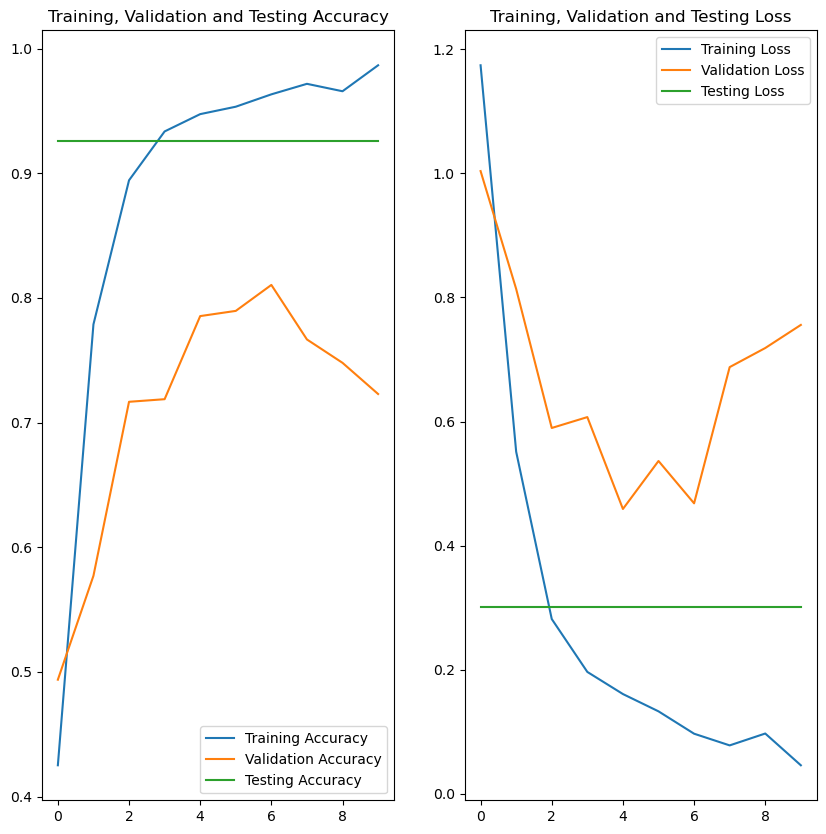

In [12]:
acc = training_result.history['accuracy']
val_acc = training_result.history['val_accuracy']
test_acc = testing_result[1]

loss = training_result.history['loss']
val_loss = training_result.history['val_loss']
test_loss = testing_result[0]

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, [test_acc]*epochs, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training, Validation and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(epochs_range, [test_loss]*epochs, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training, Validation and Testing Loss')
plt.show()


In [13]:
# def _plot_image(n=1) -> None:
#     """Plots a image and associated label."""
#     for image, label in dataset_train.take(n):
#         plt.imshow(image.numpy())
#         plt.title(dataset_label[label.numpy()])

https://www.tensorflow.org/tutorials/keras/save_and_load

In [14]:
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
print("./saved_models/"+time)
model.save_weights("./saved_models/"+time)

./saved_models/04-11-2022_09-46-16
